<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-LDPCparam-files" data-toc-modified-id="Create-LDPCparam-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create LDPCparam files</a></span></li><li><span><a href="#Test-LDPC-encoder" data-toc-modified-id="Test-LDPC-encoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test LDPC encoder</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [80]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import signal_power, calcLLR, fastBERcalc
from optic.dsp.core import pnorm
from optic.comm.fec import par2gen, encodeLDPC, decodeLDPC #ldpcDecode
from optic.models.channels import awgn
from optic.plot import pconst
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from scipy.sparse import csr_matrix, csc_matrix
from tqdm.notebook import tqdm
from numba import njit

import os.path as path

In [4]:
#from commpy.channelcoding import ldpc
#from commpy.channelcoding.ldpc import triang_ldpc_systematic_encode as encodeLDPC
#from commpy.channelcoding.ldpc import ldpc_bp_decode as decodeLDPC
#from commpy.channelcoding.interleavers import RandInterlv

In [5]:
%load_ext autoreload
%autoreload 2

## Create LDPCparam files

In [153]:
#pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'
#pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
#pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'

d = sp.io.loadmat(pathdir+'\LDPC_AR4JA_5120b_R45.mat')
#d = sp.io.loadmat(pathdir+'\LDPC_11nD2_648b_R56.mat')
#d = sp.io.loadmat('LDPC_AR4JA_1280b_R45.mat')
H = csr_matrix(d['H'])

#H = d['LDPC']['H'] # parity check matrix
#H = H[0][0][0][0][0]
#H = sp.sparse.csr_matrix.todense(H).astype(np.int8)
#H = sp.sparse.csr_matrix(H)
#H = np.asarray(H)

# file_path = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\OptiCommPy-private\optic\fecParams\LDPC_ARJA_1280b_R45.txt'

# ldpc.write_ldpc_params(H, file_path)

In [154]:
# FEC parameters
family = "AR4JA"
R = 45
n = 1280

mainDir  = path.abspath(path.join("../"))
filename = '\LDPC_' + family + '_' + str(n) + 'b_R' + str(R) + '.txt'
filePath = mainDir + r'\optic\fecParams' + filename
filePath

'C:\\Users\\edson\\OneDrive\\Documentos\\GitHub\\OptiCommPy-private\\optic\\fecParams\\LDPC_AR4JA_1280b_R45.txt'

In [155]:
G, colSwaps, Hnew = par2gen(H)

revertColSwaps = np.argsort(colSwaps)

Text(0.5, 1.0, 'Generator matrix - G')

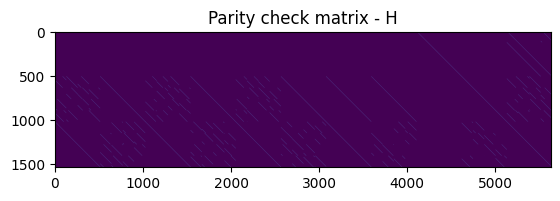

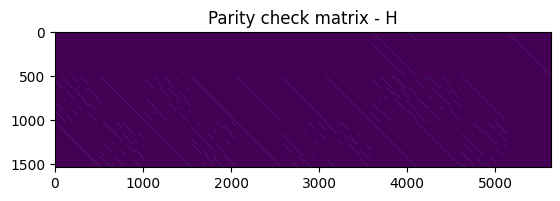

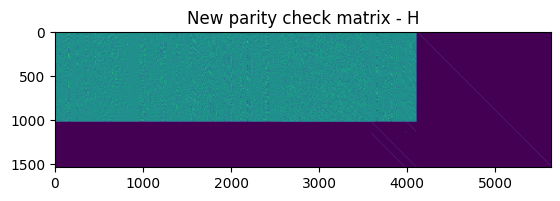

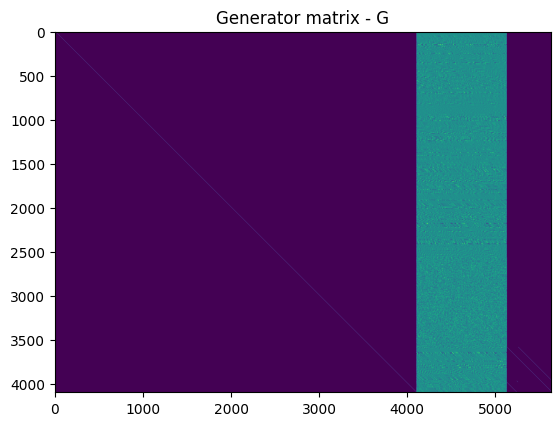

In [156]:
plt.imshow(csr_matrix.todense(H).astype(np.int8));
plt.title('Parity check matrix - H')
plt.figure()
plt.imshow(csr_matrix.todense(H[:,colSwaps]).astype(np.int8));
plt.title('Parity check matrix - H')
plt.figure()
plt.imshow(Hnew);
plt.title('New parity check matrix - H')
plt.figure()
plt.imshow(G);
plt.title('Generator matrix - G')

In [157]:
print('H :', H.shape)
print('G :', G.shape)
print('n = ', H.shape[1])
print('k = ', G.shape[0])
print('R = ', round(G.shape[0]/G.shape[1],2))

H : (1536, 5632)
G : (4096, 5632)
n =  5632
k =  4096
R =  0.73


## Test LDPC encoder

In [158]:
Nwords = 5

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords))

codedbits, colSwaps = encodeLDPC(H, bits)
np.mod(H[:,colSwaps]@codedbits,2)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
# Run AWGN simulation 
EbN0dB = 10.1
M      = 64
Nwords = 180
nIter  = 50

# modulation parameters
constSymb = grayMapping(M,'qam')             # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords))

# encode data bits with LDPC soft-FEC
codedBits, colSwaps = encodeLDPC(H, bits)
codedBitsTx = codedBits.copy().flatten()

# Map bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN    
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BERpre, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
pconst(symbRx, pType='fancy')

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, H[:,colSwaps], nIter, prgsBar=True)
decodedBits = (decodedBits.T).flatten()

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))

print('BERpreFEC = %.2e'%BERpre[0])
print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

In [172]:
Nwords = 20
nIter  = 50

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [16]  # Modulation order
EbN0dB_  = np.arange(4.5, 6, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = grayMapping(M,'qam')             # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bits = np.random.randint(2, size = (G.shape[0], Nwords))

        # encode data bits with LDPC soft-FEC
        codedBits, colSwaps = encodeLDPC(H, bits)
        codedBitsTx = codedBits.copy().flatten()

        # Map bits to constellation symbols
        symbTx = modulateGray(codedBitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx)

        # AWGN    
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
       
        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        px = np.ones(M)/M
        llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

        decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, H[:,colSwaps], nIter)
        decodedBits = (decodedBits.T).flatten()

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))        

run sim: M =  16


  0%|          | 0/30 [00:00<?, ?it/s]

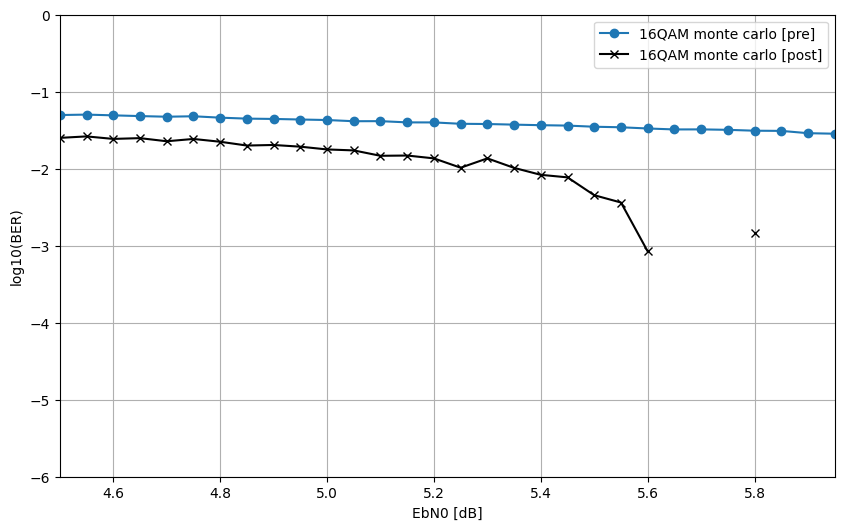

In [173]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpre[:, ii]),
        'o-',
        label=f'{str(M)}QAM monte carlo [pre]',
    )


#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpost[:, ii]),
        'kx-',
        label=f'{str(M)}QAM monte carlo [post]',
    )


plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()